In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2021-09-19 07:08:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-09-19 07:08:08 (77.6 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
data = open('/tmp/sonnets.txt').read()
type(data)

str

In [4]:
data[:100]

"FROM fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the ri"

In [5]:
corpus = data.lower().split("\n")
type(corpus)

list

In [6]:
len(corpus)

2159

In [7]:
corpus[:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

3211


In [9]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

print(len(input_sequences))

15462


In [10]:
input_sequences[:15]

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517],
 [8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61]]

In [11]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, 
                                         padding='pre'))

In [12]:
print(max_sequence_len)
print(input_sequences[:15])

11
[[  0   0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0   0  34 417 877 166]
 [  0   0   0   0   0   0  34 417 877 166 213]
 [  0   0   0   0   0  34 417 877 166 213 517]
 [  0   0   0   0   0   0   0   0   0   8 878]
 [  0   0   0   0   0   0   0   0   8 878 134]
 [  0   0   0   0   0   0   0   8 878 134 351]
 [  0   0   0   0   0   0   8 878 134 351 102]
 [  0   0   0   0   0   8 878 134 351 102 156]
 [  0   0   0   0   8 878 134 351 102 156 199]
 [  0   0   0   0   0   0   0   0   0  16  22]
 [  0   0   0   0   0   0   0   0  16  22   2]
 [  0   0   0   0   0   0   0  16  22   2 879]
 [  0   0   0   0   0   0  16  22   2 879  61]]


In [13]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = tf.keras.utils.to_categorical(label, num_classes=total_words)

In [14]:
print(predictors[:10])
print(label[:10])

[[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0  34 417 877 166]
 [  0   0   0   0   0  34 417 877 166 213]
 [  0   0   0   0   0   0   0   0   0   8]
 [  0   0   0   0   0   0   0   0   8 878]
 [  0   0   0   0   0   0   0   8 878 134]
 [  0   0   0   0   0   0   8 878 134 351]
 [  0   0   0   0   0   8 878 134 351 102]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Create the Model

In [15]:
model = Sequential()

model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))

model.add(Dense(total_words/2, 
                activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))


In [16]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [17]:
history = model.fit(predictors, 
                    label, 
                    epochs=100)


Epoch 1/100
484/484 [==============================] - 22s 25ms/step - loss: 6.9037 - accuracy: 0.0208
Epoch 2/100
484/484 [==============================] - 12s 25ms/step - loss: 6.4949 - accuracy: 0.0228
Epoch 3/100
484/484 [==============================] - 12s 24ms/step - loss: 6.3878 - accuracy: 0.0260
Epoch 4/100
484/484 [==============================] - 12s 25ms/step - loss: 6.2603 - accuracy: 0.0303
Epoch 5/100
484/484 [==============================] - 12s 25ms/step - loss: 6.1703 - accuracy: 0.0371
Epoch 6/100
484/484 [==============================] - 12s 24ms/step - loss: 6.0929 - accuracy: 0.0392
Epoch 7/100
484/484 [==============================] - 12s 25ms/step - loss: 6.0139 - accuracy: 0.0417
Epoch 8/100
484/484 [==============================] - 12s 24ms/step - loss: 5.9259 - accuracy: 0.0452
Epoch 9/100
484/484 [==============================] - 12s 25ms/step - loss: 5.8279 - accuracy: 0.0532
Epoch 10/100
484/484 [==============================] - 12s 25ms/step - l

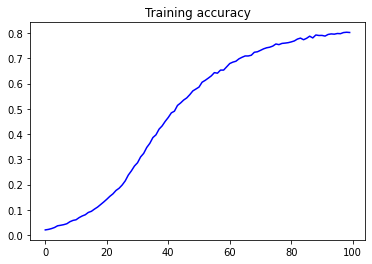

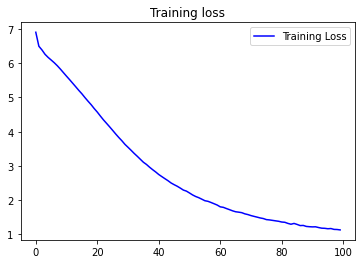

In [18]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [20]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list, verbose=0))
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my thought i praise shine praise see thee in thine own ever thine before be grow off by kings bright things new grow sad treasure days grow leaves light light light grow cold cold bearing men about than amiss clearer dying lies live for be bright seem face new muse poor eye's friend ' was die bright new rare muse alone had be tend gone there 'tis fair mine eyes thought eyes ever love him fairer here much lack ill words ill ill eye's place words eye of dwell eyes was eyes was true too short a cheer where meetness
